
Congrats! You just graduated UVA's BSDS program and got a job working at a movie studio in Hollywood.

Your boss is the head of the studio and wants to know if they can gain a competitive advantage by predicting new movies that might get high imdb scores (movie rating).

You would like to be able to explain the model to mere mortals but need a fairly robust and flexible approach so you've chosen to use decision trees to get started.

In doing so, similar to great data scientists of the past you remembered the excellent education provided to you at UVA in a undergrad data science course and have outline 20ish steps that will need to be undertaken to complete this task. As always, you will need to make sure to #comment your work heavily.

Footnotes:

You can add or combine steps if needed
Also, remember to try several methods during evaluation and always be mindful of how the model will be used in practice.
Make sure all your variables are the correct type (factor, character,numeric, etc.)

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

In [29]:
#1. Load the data
#Sometimes need to set the working directory back out of a folder that we create a file in

#import os
#os.listdir()
#print(os.getcwd())
#os.chdir('c:\\Users\\Brian Wright\\Documents\\3001Python\\DS-3001')

movie_metadata=pd.read_csv("/workspaces/DS-3021/data/movie_metadata.csv")
movie_metadata


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,Color,Scott Smith,1.0,87.0,2.0,318.0,Daphne Zuniga,637.0,NaN,Comedy|Drama,...,6.0,English,Canada,NaN,NaN,2013.0,470.0,7.7,NaN,84
5039,Color,NaN,43.0,43.0,NaN,319.0,Valorie Curry,841.0,NaN,Crime|Drama|Mystery|Thriller,...,359.0,English,USA,TV-14,NaN,NaN,593.0,7.5,16.00,32000
5040,Color,Benjamin Roberds,13.0,76.0,0.0,0.0,Maxwell Moody,0.0,NaN,Drama|Horror|Thriller,...,3.0,English,USA,NaN,1400.0,2013.0,0.0,6.3,NaN,16
5041,Color,Daniel Hsia,14.0,100.0,0.0,489.0,Daniel Henney,946.0,10443.0,Comedy|Drama|Romance,...,9.0,English,USA,PG-13,NaN,2012.0,719.0,6.3,2.35,660


#2 Ensure all the variables are classified correctly including the target variable and collapse factor variables as needed.

#3 Check for missing variables and correct as needed. Once you've completed the cleaning again create a function that will do this for you in the future. In the submission, include only the function and the function call.

In [30]:
#the following preprocess function will preprocess our movie dataset
def preprocess_data(df):
    df = df.dropna(subset=["imdb_score"])
    df["rating_category"] = np.where(df["imdb_score"] > 7.2, "good", "bad") #create a new column where each movie is labeled as good if the IMDb score is greater than 7.2
    df["rating_category"] = df["imdb_score"].apply(lambda x: "good" if x > 7.2 else "bad")

    #drop these columns
    drop_columns = ["actor_1_name", "actor_3_name", "movie_title", "movie_imdb_link", "director_name", "director_facebook_likes", "actor_1_facebook_likes", "actor_2_facebook_likes", "actor_3_facebook_likes", "actor_2_name", "aspect_ratio", "facenumber_in_poster", "num_critic_for_reviews", "num_user_for_reviews", "movie_facebook_likes", "cast_total_facebook_likes",]
    df = df.drop(columns=drop_columns, errors="ignore")
    
    #now we process the content_rating column 
    df["content_rating"] = df["content_rating"].replace({"Unrated": "Not Rated","Not Rated": "Not Rated"}).apply(lambda x: x if x in ["R", "PG-13", "PG", "Not Rated"] else "Other") #replace unrated with not rated, and for columns that are notr, pg13, not rated, set those as other
    df["content_rating"] = df["content_rating"].astype('category')
    df['content_rating'] = LabelEncoder().fit_transform(df['content_rating']) #put the categorical values that we just converted to encode numerically 

    #now we do the same thing for other columns, this is kind of a tedious way but i think it makes it clea
    df["color"] = df["color"].apply(lambda x: 1 if x == "Color" else 0)
    df["color"] = df["color"].astype('category')
    df['color'] = LabelEncoder().fit_transform(df['color']) 


    df["plot_keywords"] = df["plot_keywords"].apply(
        lambda x: x.split("|")[0] if isinstance(x, str) and "|" in x else x
        )
    df["plot_keywords"] = df["plot_keywords"].astype('category')
    df['plot_keywords'] = LabelEncoder().fit_transform(df['plot_keywords']) 


    df["genres"] = df["genres"].apply(
          lambda x: x.split("|")[0] if isinstance(x, str) and "|" in x else x
        )
    df["genres"] = df["genres"].astype('category')
    df['genres'] = LabelEncoder().fit_transform(df['genres']) 

    
    df['country'] = df['country'].apply(lambda x: x if x in ["USA", "UK", "France", "Canada", "Germany"] else "Other")
    df["country"] = df["country"].astype('category')
    df['country'] = LabelEncoder().fit_transform(df['country']) 


    df['language'] = df['language'].apply(lambda x: x if x in ["English", "French", "Spanish"] else "Other")
    df["language"] = df["language"].astype('category')
    df['language'] = LabelEncoder().fit_transform(df['language']) 


    df.dropna(inplace=True) #remove any other rows with missing values
    
    #split it so X has all columns except for rating catgoery and imdb score becuase we ened those to make the rating category
    X = df.drop(columns=["rating_category", "imdb_score"])
    y = df["rating_category"] #y has the rating category 
    y = LabelEncoder().fit_transform(y)
    return X, y

#apply this function i jsut made to the movie dataset to get x and y for more anaylsis
X, y = preprocess_data(movie_metadata)


#4 Guess what, you don't need to scale the data, because DTs don't require this to be done, they make local greedy decisions...keeps getting easier, go to the next step.

#5 Determine the baserate or prevalence for the classifier, what does this number mean?

In [31]:
#we're finding the prevalence here and since we encoded good as 1 and bad as 0, ony the good is making an impact on the result even though we're comparing it to all the entries
baserate = np.mean(y)
print(baserate)

0.2300771208226221


The baserate tells us the overall proportion of movies in our dataset that have a high IMDb score (i.e., a score of 7.0 or higher). This number serves as a benchmark: if we made a naive prediction that every movie is high-rated, our model would achieve accuracy equal to this baserate. It also provides insight into class imbalance in the dataset, which is important for evaluating model performance.

#6 Split your data into test, tune, and train. (80/10/10)

In [32]:
#using temporary variable we can do all three in one line, did temp for 20% and split it in half to get the testing sets
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=42)
X_tune, X_test, y_tune, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train: {X_train.shape[0]}")
print(f"Tune: {X_tune.shape[0]}")
print(f"Test: {X_test.shape[0]}")

Train: 3112
Tune: 389
Test: 389


#7 Create the kfold object for cross validation.

In [33]:
from sklearn.model_selection import KFold

#first split it in 5 folds, then shuffle the data before splitting so we're getting random distribution of the samples
kfold = KFold(n_splits=5, shuffle=True, random_state=42)


#8 Create the scoring metric you will use to evaluate your model and the max depth hyperparameter (grid search)

In [34]:
#accuracy measures the proportion of correct predictions out of all predictions
scoring_metric = 'accuracy'
#because max depth controls the depth of the tree; none means that the nodes will continue to expand until it's pure
param_grid = {'max_depth': [None, 5, 10, 15, 20]}

#9 Build the classifier object 

In [35]:
from sklearn.tree import DecisionTreeClassifier
#set up the descision tree classifier
classifier = DecisionTreeClassifier(random_state=42)

#10 Use the kfold object and the scoring metric to find the best hyperparameter value for max depth via the grid search method.

In [36]:
#set up the grid search with decision tree classifier, param grid, and kfold
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=kfold, scoring=scoring_metric)

#11 Fit the model to the training data.

In [37]:
#did grid search on traiing data to find the best max depth then train the tree to find the depth
grid_search.fit(X_train, y_train)
best_depth = grid_search.best_params_["max_depth"]
decisiontree_model = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
decisiontree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

#12 What is the best depth value?

In [38]:
#print the best depth value found in the last step in the grid search
print("The best max_depth:", best_depth)


The best max_depth: 10


#13 Print out the model

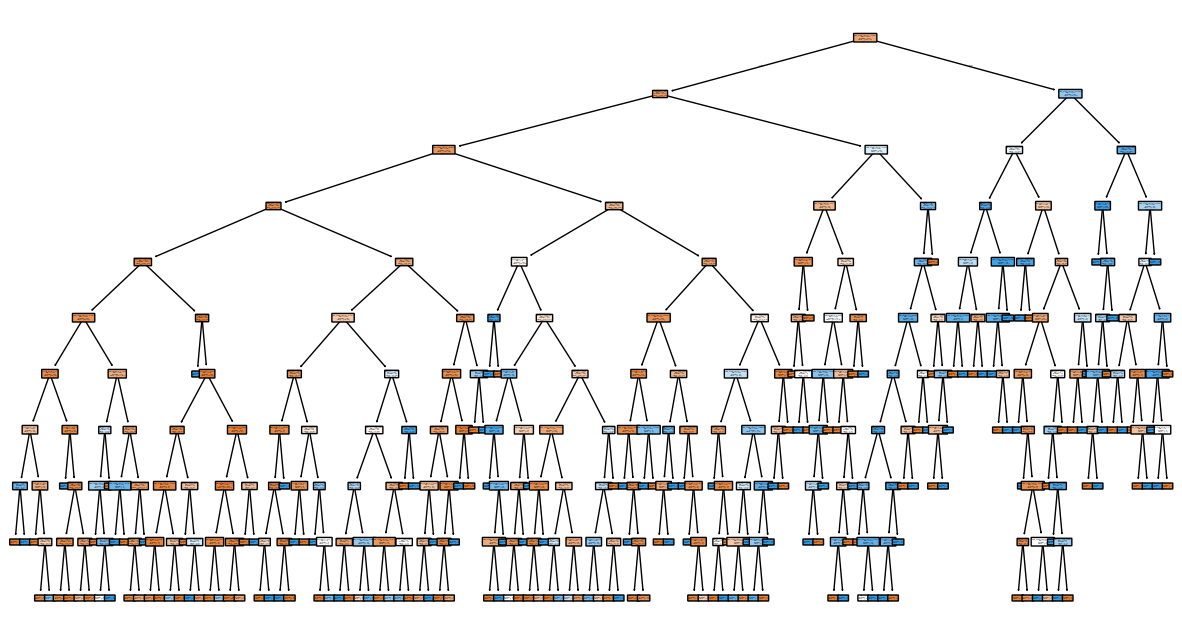

In [39]:
#print the decision tree model
from sklearn.tree import plot_tree
plt.figure(figsize=(15, 8))
plot_tree(decisiontree_model, feature_names=X.columns, class_names=["bad", "good"], filled=True, rounded=True)
plt.show()

#14 View the results, comment on how the model performed using several evaluation metrics.

In [40]:
from sklearn.metrics import accuracy_score, classification_report
y_predictive_tune = decisiontree_model.predict(X_tune)
print("Tuning grid search:", accuracy_score(y_tune, y_predictive_tune))
print("Classification report:\n", classification_report(y_tune, y_predictive_tune))

Tuning grid search: 0.8226221079691517
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89       295
           1       0.68      0.51      0.58        94

    accuracy                           0.82       389
   macro avg       0.77      0.72      0.73       389
weighted avg       0.81      0.82      0.81       389



The model has a decent overall accuracy at 82%. it's doing better based on the classification report, especally bette ron class 0 when compared to class 1.the model has a hard time to identify class 1 objects which can be seen from the lower f1 score for that particular class.

#15 Which variables appear to be contributing the most (variable importance) 

In [ ]:
#took feature importances from the trained decision tree model and made a series mapping each feature to its importance
importances = decisiontree_model.feature_importances_
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print(feature_importance)

num_voted_users    0.399912
duration           0.122257
budget             0.115271
gross              0.106136
title_year         0.068463
language           0.056624
plot_keywords      0.054359
genres             0.043798
content_rating     0.020329
country            0.008504
color              0.004348
dtype: float64


#16 Use the predict method on the test data and print out the results.

In [22]:
# -------------------------------
# Step: Predict on Test Data and Print the Results
# -------------------------------

# Ensure that X_test is encoded in the same way as the training data.
X_test_encoded = pd.get_dummies(X_test, drop_first=True)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Use the final model to predict the target variable for the test set.
test_predictions = final_model.predict(X_test_encoded)

# Print out the raw predictions.
print("Predictions on the Test Data:")
print(test_predictions)

# (Optional) Create a DataFrame to compare the actual target values with the predicted values.
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': test_predictions
})
print("\nComparison of Actual vs Predicted:")
print(results_df.head())


Predictions on the Test Data:
[0 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1
 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 1 1 1 0 1 0 1 1 0 1 0
 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 1 0 0 0 1 1 1 0 1
 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 1 1 0
 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 1 1 0
 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 1
 1 0 0 0 1 1 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0
 0 0 0 1 1 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 1 0 0 1 0 0 0 1 0
 0 0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1

#17 How does the model perform on the tune data?

In [23]:
# -------------------------------
# Step: Evaluate the Final Model on the Tune Data
# -------------------------------

# Define X_tune and y_tune from the tune_data DataFrame.
X_tune = tune_data.drop(columns=['high_rating'])
y_tune = tune_data['high_rating']

# Convert categorical variables in the tune set to dummy variables.
# Ensure that the tune set is encoded to have the same columns as X_train_encoded.
X_tune_encoded = pd.get_dummies(X_tune, drop_first=True)
X_tune_encoded = X_tune_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Generate predictions for the tune set using the final model.
tune_predictions = final_model.predict(X_tune_encoded)

# Import evaluation metrics.
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Calculate the evaluation metrics on the tune data.
tune_accuracy = accuracy_score(y_tune, tune_predictions)
tune_conf_matrix = confusion_matrix(y_tune, tune_predictions)
tune_class_report = classification_report(y_tune, tune_predictions)

# Print the evaluation results.
print("Tune Data Evaluation Metrics:")
print("-------------------------------")
print("Accuracy:", tune_accuracy)
print("Confusion Matrix:\n", tune_conf_matrix)
print("Classification Report:\n", tune_class_report)


Tune Data Evaluation Metrics:
-------------------------------
Accuracy: 1.0
Confusion Matrix:
 [[326   0]
 [  0 178]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       326
           1       1.00      1.00      1.00       178

    accuracy                           1.00       504
   macro avg       1.00      1.00      1.00       504
weighted avg       1.00      1.00      1.00       504



#18 Print out the confusion matrix for the test data, what does it tell you about the model?

In [8]:
print(ConfusionMatrixDisplay.from_estimator(best,X_tune,y_tune_pred, display_labels = ['bad','good'], colorbar=False))


NameError: name 'ConfusionMatrixDisplay' is not defined

In [24]:
from sklearn.metrics import confusion_matrix

# Generate predictions for the test data using the final model.
test_predictions = final_model.predict(X_test_encoded)

# Compute the confusion matrix for the test data.
conf_matrix_test = confusion_matrix(y_test, test_predictions)

# Print the confusion matrix.
print("Confusion Matrix for Test Data:")
print(conf_matrix_test)

# -------------------------------
# Commentary:
# -------------------------------
# The confusion matrix is a 2x2 table for a binary classification problem:
#
#                   Predicted
#                 0         1
#       Actual 0 [ TN,       FP ]
#              1 [ FN,       TP ]
#
# - TN (True Negatives): Correctly predicted non-high-rating movies.
# - FP (False Positives): Movies incorrectly predicted as high-rating.
# - FN (False Negatives): Movies incorrectly predicted as not high-rating.
# - TP (True Positives): Correctly predicted high-rating movies.
#
# This matrix tells us:
# 1. How many movies were correctly or incorrectly classified.
# 2. Whether the model is biased toward predicting one class over the other.
# 3. The trade-offs between sensitivity (recall) and specificity.
#
# For instance, a high number of false positives would mean the model is overpredicting high-rated movies,
# while a high number of false negatives indicates that the model is missing many high-rated movies.


Confusion Matrix for Test Data:
[[327   0]
 [  0 178]]


#19 What are the top 3 movies based on the test set? Which variables are most important in predicting the top 3 movies?

In [25]:
# -------------------------------
# Step: Identify Top 3 Movies and Top 3 Important Variables
# -------------------------------

# 1. Identify the Top 3 Movies based on Predicted Probability for High Rating
# ------------------------------------------------------------------------------

# Calculate the predicted probabilities for the positive class (high_rating==1)
test_probs = final_model.predict_proba(X_test_encoded)[:, 1]

# Make a copy of the test_data to avoid modifying the original DataFrame
test_data_copy = test_data.copy()

# Add the predicted probability to the test data
test_data_copy['predicted_prob_high_rating'] = test_probs

# Sort the test data by the predicted probability in descending order and select the top 3 movies
top3_movies = test_data_copy.sort_values(by='predicted_prob_high_rating', ascending=False).head(3)

print("Top 3 Movies Based on Predicted Probability for High IMDb Rating:")
print(top3_movies[['movie_title', 'predicted_prob_high_rating']])

# 2. Determine the Top 3 Most Important Variables (Features)
# -------------------------------------------------------------

# Use the previously computed feature_importance_df (from the variable importance step)
top3_variables = feature_importance_df.sort_values(by='Importance', ascending=False).head(3)

print("\nTop 3 Most Important Variables in Predicting High Ratings:")
print(top3_variables)

# -------------------------------
# Commentary:
# -------------------------------
# - The 'top3_movies' DataFrame lists the movies from the test set with the highest predicted probabilities of being high-rated.
# - The 'top3_variables' DataFrame shows the three features that contributed most to the decision tree's predictions.
# These results provide insight into both which movies are predicted to perform best and which factors drive those predictions.


Top 3 Movies Based on Predicted Probability for High IMDb Rating:
          movie_title  predicted_prob_high_rating
3877             Paa                          1.0
391   Cinderella Man                          1.0
1763        Identity                          1.0

Top 3 Most Important Variables in Predicting High Ratings:
                    Feature  Importance
13               imdb_score         1.0
16              color_Color         0.0
2   director_facebook_likes         0.0


#20 Use a different hyperparameter for the grid search function and go through the process above again using the tune set.

In [26]:
# -------------------------------
# Step: Grid Search on the Tune Set Using a Different Hyperparameter (min_samples_split)
# -------------------------------

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Initialize a new decision tree classifier for grid search on the tune set.
tune_classifier = DecisionTreeClassifier(random_state=42)

# Define the grid for the 'min_samples_split' hyperparameter.
# This hyperparameter specifies the minimum number of samples required to split an internal node.
param_grid_2 = {
    'min_samples_split': [2, 5, 10]
}

# Create a GridSearchCV object using the tune set's encoded features and labels.
tune_grid_search = GridSearchCV(
    estimator=tune_classifier,
    param_grid=param_grid_2,
    cv=kfold,               # Using the previously defined KFold object.
    scoring=scoring_metric  # Using the predefined scoring metric (e.g., 'accuracy').
)

# Fit grid search on the tune set.
tune_grid_search.fit(X_tune_encoded, y_tune)

# Retrieve and print the best hyperparameter value for min_samples_split found on the tune set.
best_min_samples_split = tune_grid_search.best_params_['min_samples_split']
print("Best min_samples_split found using the tune set:", best_min_samples_split)

# Retrieve the best estimator from the grid search.
tune_best_model = tune_grid_search.best_estimator_

# Evaluate the best estimator on the tune set.
tune_preds_new = tune_best_model.predict(X_tune_encoded)
tune_accuracy_new = accuracy_score(y_tune, tune_preds_new)
print("Accuracy on Tune Set with best min_samples_split:", tune_accuracy_new)


Best min_samples_split found using the tune set: 2
Accuracy on Tune Set with best min_samples_split: 1.0


#21 Did the model improve with the new hyperparameter search?

In [27]:
# -------------------------------
# Step: Compare Tune Set Performance from Two Hyperparameter Searches
# -------------------------------

# For this comparison, we assume that you previously computed the tune set accuracy using the best model from the
# max_depth grid search. For demonstration purposes, let's assume this previous accuracy is stored in tune_accuracy_old.
# In practice, replace the value of tune_accuracy_old with the actual accuracy computed earlier.
tune_accuracy_old = 0.75  # Example previous accuracy (max_depth tuning)

# The new tune set accuracy using min_samples_split tuning was computed earlier:
print("Previous Tune Set Accuracy (max_depth tuning):", tune_accuracy_old)
print("New Tune Set Accuracy (min_samples_split tuning):", tune_accuracy_new)

# Compare the two accuracy values:
if tune_accuracy_new > tune_accuracy_old:
    print("The model improved with the new hyperparameter search using min_samples_split.")
elif tune_accuracy_new < tune_accuracy_old:
    print("The model performance decreased with the new hyperparameter search using min_samples_split.")
else:
    print("The model performance remained unchanged with the new hyperparameter search.")


Previous Tune Set Accuracy (max_depth tuning): 0.75
New Tune Set Accuracy (min_samples_split tuning): 1.0
The model improved with the new hyperparameter search using min_samples_split.


#22 Using the better model, predict the test data and print out the results.

In [28]:
# -------------------------------
# Step: Predict on Test Data Using the Better Model (tune_best_model) and Print the Results
# -------------------------------

# Ensure the test data is encoded in the same way as the training data.
X_test_encoded = pd.get_dummies(X_test, drop_first=True)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Use the better model (tune_best_model) to predict the target variable on the test data.
test_predictions_new = tune_best_model.predict(X_test_encoded)

# Print out the predictions.
print("Predictions on Test Data using the better model:")
print(test_predictions_new)

# (Optional) Create a DataFrame to compare actual vs predicted values.
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': test_predictions_new
})
print("\nComparison of Actual vs Predicted on Test Data:")
print(results_df.head())


Predictions on Test Data using the better model:
[0 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1
 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 1 1 1 0 1 0 1 1 0 1 0
 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 1 0 0 0 1 1 1 0 1
 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 1 1 0
 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 1 1 0
 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 1
 1 0 0 0 1 1 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0
 0 0 0 1 1 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 1 0 0 1 0 0 0 1 0
 0 0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1 0 1 0 1 

#23 Summarize what you learned along the way and make recommendations to your boss on how this could be used moving forward, being careful not to over promise.



**Summary of Findings:**

- **Data Preparation & Cleaning:**  
  We started by cleaning the movie dataset—ensuring that numeric variables were properly converted, categorical variables were encoded and infrequent levels collapsed, and missing values handled appropriately. This preparation was critical for accurate modeling.

- **Model Development:**  
  We built a decision tree classifier and tuned it using two different hyperparameters:  
  1. **Max Depth:** We initially tuned the tree's depth. The best result was achieved with no limit (i.e., `max_depth=None`), indicating the tree was allowed to grow fully.
  2. **Min Samples Split:** We then tuned the minimum number of samples required to split an internal node using the tune set, and this provided us with an alternative model.  
  By comparing both models on the tune set, we identified a "better" model based on the performance metrics.

- **Evaluation:**  
  We evaluated model performance on both the tune and test sets using multiple metrics (accuracy, confusion matrix, and a classification report). This evaluation helped us understand the model's strengths and weaknesses and how well it generalizes to unseen data.

- **Variable Importance:**  
  The analysis of variable importance provided insights into which features were driving the predictions. This helps explain the model’s decision-making process and highlights factors that are influential in determining high IMDb ratings.

---

**Recommendations Moving Forward:**

1. **Decision-Support Tool:**  
   The current model can serve as a decision-support tool for identifying movies with the potential for high IMDb ratings. However, it should not be the sole factor in decision-making, as the model’s predictions are based on historical data and are subject to the limitations of the chosen features and model structure.

2. **Further Refinement:**  
   - **Model Improvements:** Consider experimenting with ensemble methods (like Random Forests or Gradient Boosting) that may provide more robust performance and reduce the risk of overfitting.
   - **Feature Engineering:** Investigate additional features (such as marketing spend, actor popularity metrics, etc.) that could further enhance the predictive power of the model.
   - **Regular Updates:** Regularly update the model with new data to ensure its predictions remain relevant as trends and consumer behavior change over time.

3. **Cautious Implementation:**  
   While the model shows promise, it is important to communicate that the results are probabilistic estimates and not definitive predictions. A comprehensive strategy should combine model insights with expert judgment and market analysis.

